In [1]:
%pip install geopandas rasterio matplotlib scikit-learn pandas pyimpute xgboost lightgbm geojson rasterstats

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import logging
import rasterio
from tqdm.auto import tqdm
import geopandas as gpd
import shutil
import glob
#from pyimpute import load_training_vector
#from pyimpute import load_targets
import numpy as np
import pandas as pd

In [3]:
# Adapted from pyimpute for tqdm
logger = logging.getLogger("pyimpute")

def load_training_vector_with_progress(
    response_shapes, explanatory_rasters, response_field, metric="mean"
):
    from rasterstats import zonal_stats

    all_means = []
    all_zones = None

    for i, raster in enumerate(tqdm(explanatory_rasters, desc="Training Vectors")):
        logger.debug("Rasters stats on %s" % raster)

        stats = zonal_stats(
            response_shapes, raster, stats=metric, prefix="pyimpute_", geojson_out=True
        )

        zones = [x["properties"][response_field] for x in stats]
        if all_zones:
            assert zones == all_zones
        else:
            all_zones = zones

        means = [x["properties"]["pyimpute_" + metric] for x in stats]
        all_means.append(means)

    train_y = np.array(all_zones)
    train_xs = np.array(all_means).T

    return train_xs, train_y

def load_targets_with_progress(explanatory_rasters):

    explanatory_raster_arrays = []
    transform = None
    shape = None
    crs = None

    for raster in tqdm(explanatory_rasters, ascii=True, desc="Target Vectors"):
        logger.debug(raster)
        with rasterio.open(raster) as src:
            ar = src.read(1)  # TODO band num?

            # Save or check the geotransform
            if not transform:
                transform = src.transform
            else:
                assert transform.almost_equals(src.transform)

            # Save or check the shape
            if not shape:
                shape = ar.shape
            else:
                assert shape == ar.shape

            # Save or check the geotransform
            if not crs:
                crs = src.crs
            else:
                assert crs == src.crs

        # Flatten in one dimension
        arf = ar.flatten()
        explanatory_raster_arrays.append(arf)

    expl = np.array(explanatory_raster_arrays).T

    raster_info = {
        "transform": transform,
        "shape": shape,
        "crs": crs,
    }
    return expl, raster_info


# Species Distribution Data Loading

In [4]:
os.makedirs("inputs/historical", exist_ok = True)
os.makedirs("inputs/future", exist_ok = True)
os.makedirs("outputs", exist_ok = True)

In [5]:
filetype = 'geojson'
species = 'Anser_albifrons'

for f in sorted(glob.glob('data/' + filetype + '/*')):
    shutil.copy(f,'inputs/')

pa_raw = gpd.GeoDataFrame.from_file('inputs/' + species + '.' + filetype)

In [6]:
sample_size = 3000

pa = pa_raw.sample(n=sample_size, random_state=1)
pa.sample(5)

,CLASS,geometry
103814,0.0,POINT (-89.56250 33.81250)
37921,0.0,POINT (-77.06250 49.10417)
42211,0.0,POINT (-74.27083 -3.93750)
8688,0.0,POINT (-68.10417 -28.97917)
204857,0.0,POINT (-104.68750 66.64583)


In [7]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

print("\nnumber of presences: ", pa[pa.CLASS == 1].count())
print("number of absences: ", pa[pa.CLASS == 0].count())

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: EPSG:4326
3000 observations with 2 columns

number of presences:  CLASS       959
geometry    959
dtype: int64
number of absences:  CLASS       2041
geometry    2041
dtype: int64


# Climate Data Loading and Preprocessing

Load Climate Data

In [8]:
# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/bioclim/bclim*.asc')):
    shutil.copy(f,'inputs/historical/')
raster_features = sorted(glob.glob(
    'inputs/historical/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')


There are 19 raster features.


In [20]:
try:
    # Load training vectors from file
    train_xs = np.genfromtxt("inputs/model_inputs/" + species + "_" + str(sample_size) + "_train_xs.csv", delimiter=',')
    train_y = np.genfromtxt("inputs/model_inputs/" + species + "_" + str(sample_size) + "_train_y.csv", delimiter=',')
except Exception as error:
    print(error)
    train_xs, train_y = load_training_vector_with_progress(pa, raster_features, response_field='CLASS')

    # Remove NaN rows (why do they exist?)
    df = pd.DataFrame(train_xs)
    row_index = df.index[df.isna().any(axis=1)].tolist()
    print("NaN Rows:", row_index)

    train_xs = np.delete(train_xs, row_index, axis=0)
    train_y = np.delete(train_y, row_index, axis=0)

    # Save to csv for faster prototyping
    df_x = pd.DataFrame(train_xs)
    df_y = pd.DataFrame(train_y)
    os.makedirs("inputs/model_inputs", exist_ok = True)
    df_x.to_csv("inputs/model_inputs/" + species + "_" + str(sample_size) + "_train_xs.csv", header = False, index = False)
    df_y.to_csv("inputs/model_inputs/" + species + "_" + str(sample_size) + "_train_y.csv", header = False, index = False)

target_xs, raster_info = load_targets_with_progress(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

Target Vectors:   0%|          | 0/19 [00:00<?, ?it/s]

((2993, 19), (2993,))

and we implemement several `scikit-learn` classifiers:

In [39]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle
from matplotlib import pyplot

CLASS_MAP = {
    'random_forest': (RandomForestClassifier()),
    'extra_trees': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    'lgbm': (LGBMClassifier()),
    }

from pyimpute import impute
from sklearn import model_selection
# model fitting and spatial range prediction
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs, train_y)

    os.makedirs('outputs/models/', exist_ok=True)
    filename = species + "_" + name + '_classifier_model.pkl'
    pickle.dump(model, open('outputs/models/' + filename, 'wb'))

c:\Users\marche\anaconda3\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


random_forest 5-fold Cross Validation Accuracy: 89.44 (+/- 2.73)
extra_trees 5-fold Cross Validation Accuracy: 88.81 (+/- 2.71)
xgb 5-fold Cross Validation Accuracy: 88.77 (+/- 3.51)
[LightGBM] [Info] Number of positive: 766, number of negative: 1628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4712
[LightGBM] [Info] Number of data points in the train set: 2394, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.319967 -> initscore=-0.753925
[LightGBM] [Info] Start training from score -0.753925
[LightGBM] [Info] Number of positive: 766, number of negative: 1628
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4714

# Predictive Modelling

In [32]:
os.makedirs("inputs/future", exist_ok=True)

range = "2021-2040"
ssp = "ssp585"

# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/future/' + range + '/' + ssp + '/bclim*.asc')):
    shutil.copy(f,'inputs/future')
raster_features = sorted(glob.glob(
    'inputs/future/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'future raster features.')


There are 19 future raster features.


In [33]:
target_xs, raster_info = load_targets_with_progress(raster_features)

Target Vectors:   0%|          | 0/19 [00:00<?, ?it/s]

In [43]:
classifiers =[
    'random_forest',
    'extra_trees',
    'xgb',
    'lgbm'
]

# model fitting and spatial range prediction
for name in classifiers:    
    # spatial prediction
    pickle_filename = "outputs/models/" + species + '_' + name + "_classifier_model.pkl"
    model = pickle.load(open(pickle_filename, 'rb'))

    os.makedirs('outputs/' + species + '-future/' + name + '-images', exist_ok=True)
    impute(target_xs, model, raster_info, outdir='outputs/' + species + '-future/' + name + '-images',
            class_prob=True, certainty=True)

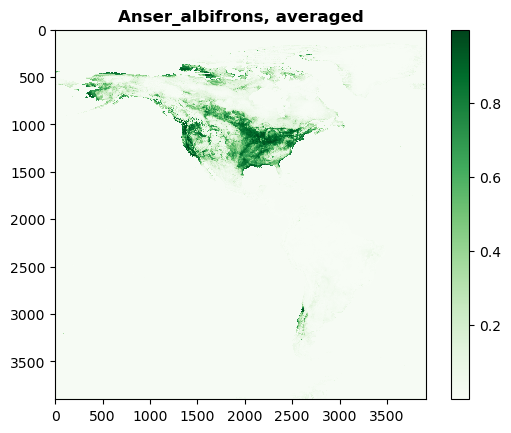

In [45]:
from pylab import plt

def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

distr_rf = rasterio.open('outputs/' + species + '-future/random_forest-images/probability_1.0.tif').read(1)
distr_et = rasterio.open('outputs/' + species + '-future/extra_trees-images/probability_1.0.tif').read(1)
distr_xgb =  rasterio.open('outputs/' + species + '-future/xgb-images/probability_1.tif').read(1)
distr_lgbm =  rasterio.open('outputs/' + species + '-future/lgbm-images/probability_1.0.tif').read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, species + ", averaged", cmap="Greens")